<a target="_blank" href="https://colab.research.google.com/github/vinicius-souza-lima/mvp_ml/blob/main/mvp_ml.ipynb"> <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/> </a>

In [1]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt
from typing import Literal
from PIL import Image
from sklearn.model_selection import (
    train_test_split,
    cross_val_predict,
    cross_val_score,
    KFold,
)
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
)
from sklearn.base import BaseEstimator, TransformerMixin
import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns
import math
import fsspec
from sklearn.model_selection import RandomizedSearchCV
from sklearn.calibration import label_binarize
import kagglehub

/home/vinicius/dev/mvp_ml/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Problema de Classificação (Algoritmos Clássicos)

In [49]:
class Dataset:
    def __init__(
        self,
        name: str,
        path_dir: str,
    ):
        self.name = name
        self.data = None
        self.path_dir = path_dir
        self.files = None

    def load_dataset(self):
        dir = Path(self.path_dir)
        files = dir.rglob("*.jpeg")
        self.files = files

    def convert_toarray(
        self,
        target_values: list[str],
        fallback: str | None = None,
        resolution: tuple[int, int] = (128, 128),
    ):
        imgs = []
        targets = []

        for f in self.files:
            if f.is_dir():
                continue

            imgs.append(
                np.array(
                    Image.open(str(f))  # Lê a imagem
                    .convert("L")  # Converte para escala de cinza
                    .resize(
                        resolution, Image.Resampling.LANCZOS
                    )  # Redimensiona a imagem
                ).flatten()  # Formata a matriz como array
            )
            targets.append(
                next(
                    (1 for cat in f.name.split("_") if cat in target_values),
                    fallback,  # procura categoria no nome do arquivo
                )
            )

        return np.stack(imgs), np.array(targets).astype(np.bool)

    def save_converted(self, X: npt.ArrayLike, y: npt.ArrayLike) -> None:
        def dividir_array(X: npt.NDArray, max_size_mb=24):
            tam_x = X.nbytes
            tam_max = 1024 * 1024 * max_size_mb

            n_elem = math.ceil(tam_x / tam_max)
            return np.array_split(X, n_elem)

        cwd = Path(".")
        (cwd / "datasets").mkdir(exist_ok=True)
        (cwd / "datasets" / f"{self.name}").mkdir(exist_ok=True)
        (cwd / "datasets" / f"{self.name}" / "X").mkdir(exist_ok=True)
        (cwd / "datasets" / f"{self.name}" / "y").mkdir(exist_ok=True)

        data_path = cwd / "datasets" / f"{self.name}"

        for i, array in enumerate(dividir_array(X)):
            np.save(str(data_path / "X" / f"X_{i}"), array)  # Save x

        for i, array in enumerate(dividir_array(y)):
            np.save(str(data_path / "y" / f"y_{i}"), array)  # Save y

    @staticmethod
    def load_converted(path: str):
        X = []
        y = []
        path_x = Path(path) / "X"
        for file in sorted(path_x.glob("*")):
            X.append(np.load(str(file)))
        X = np.vstack(X)

        path_y = Path(path) / "y"
        for file in sorted(path_y.glob("*")):
            y.append(np.load(str(file)))
        y = np.vstack(y)

        return X, y.reshape((-1, 1))

    @staticmethod
    def download_from_remote(
        owner: str,
        repo: str,
        folder: str,
        destination: Path = Path("."),
    ):
        """
        Baixa pasta de repositório remoto do github de forma
        recursiva.
        """
        fs = fsspec.filesystem(protocol="github", org=owner, repo=repo)
        local_dir = destination / folder
        local_dir.mkdir(exist_ok=True, parents=True)
        fs.get(folder, local_dir.as_posix(), recursive=True)

Inicialmente foi usado o código abaixo para baixar o dataset de imagens do repositório do Kaggle

In [50]:
#path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")
path_chest = Path("/home/vinicius/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/") / "chest_xray" / "chest_xray"
chest_data = Dataset("chest",path_chest)
chest_data.load_dataset()
X_chest,y_chest = chest_data.convert_toarray(["bacteria","virus"],0,(128,128))
chest_data.save_converted(X_chest,y_chest)

Nos usos subsequentes usou-se o dataset já armazenado no repositório remoto

In [3]:
#Dataset.download_from_remote("vinicius-souza-lima", "mvp_ml", "datasets")
X_chest, y_chest = Dataset.load_converted("datasets/chest")

In [6]:
resolution = (128, 128)

### Definição do Problema

#### Descrição do problema

 Classificar imagem de raio x de paciente em saudável, pneumonia bacteriana ou pneumonia virótica

#### Premissas ou hipóteses sobre o problema

É assumido que para dada imagem, existem apenas três possibilidades para classificação em relação a pneumonia:

- `Normal`: Significa que o paciente não possui pneumonia.
- `Bactéria`: Signica que o paciente possui pneumonia causada por bactéria.
- `Virus`: Significa que o paciente possui pneumonia virótica. 

#### Restrições para selecionar os dados

Os dados selecionados foram provenientes de um dataset já existente hospedado no Kaggle.

#### Descrição do Dataset

O dataset consiste de 5856 imagens de raio-x de alta resolução da região toráxica que foram redimensionadas para a resolução de 128x128 para facilitar o processamento de imagens 

In [4]:
X_chest.shape

(5856, 16384)

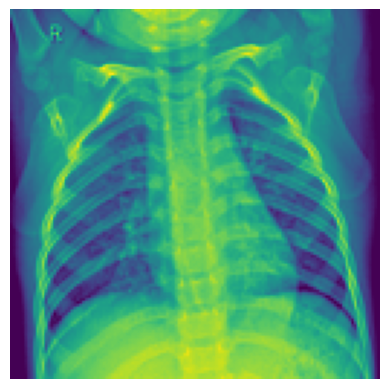

In [5]:
plt.imshow(X_chest[4000].reshape((128,128)))
plt.axis("off")
plt.show()

### Preparação dos dados

#### Separação do Dataset em treino e teste

In [51]:
X_chest_train, X_chest_test, y_chest_train, y_chest_test = train_test_split(
    X_chest, y_chest, test_size=0.2, random_state=42, stratify=y_chest
)

num_particoes = 5
kfold = KFold(n_splits=num_particoes, shuffle=True, random_state=42)

#### Data Augmentation

In [7]:
from sklearn.discriminant_analysis import StandardScaler
from sklearn.pipeline import FunctionTransformer, Pipeline


pre = Pipeline(
    [
        ("converte_float", FunctionTransformer(lambda X: X.astype("float64"))),
        ("normalizacao", StandardScaler()),
    ]
)

In [52]:
X_chest_train_pre = pre.fit_transform(X_chest_train)

In [ ]:
class Augmenter(BaseEstimator, TransformerMixin):
    def __init__(
        self, rotation_range=10, width_shift_range=0.1, height_shift_range=0.1
    ):
        self.rotation_range = rotation_range
        self.width_shift_range = width_shift_range
        self.height_shift_range = height_shift_range

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        np.random.normal(0, 1, X.shape)

### Modelagem e treinamento

Como o a classe `bacteria` é bem mais comum que as demais, foi considerada a métrica de `balanced_accuracy` para levar em conta o desbalanceamento das classes na escolha dos modelos.

In [53]:
def choose_model(
    scoring: Literal["accuracy", "balanced_accuracy", "f1_macro"] = "accuracy",
    seed: int = 42,
    n_jobs = 3
):
    np.random.seed(seed)
    results = []

    models = {
        "NB": GaussianNB(),  # 5 sec
        "KNN": KNeighborsClassifier(),  # 12 sec
        "RF": RandomForestClassifier(),  # +- 3 min
        "CART": DecisionTreeClassifier(),  # +- 7 min
    }

    for name, model in models.items():
        cv_results = cross_val_score(
            model,
            X_chest_train_pre,
            y_chest_train.ravel(),
            cv=kfold,
            scoring=scoring,
            n_jobs=n_jobs,
        )
        results.append(cv_results)
        print(f"{name}: Média: {cv_results.mean():.3f}, std:{cv_results.std():.3f}")

    return results

In [54]:
scoring = "precision"
results = choose_model(scoring=scoring, seed=42,n_jobs=1)

NB: Média: 0.943, std:0.010
KNN: Média: 0.906, std:0.005
RF: Média: 0.948, std:0.008
CART: Média: 0.907, std:0.016


/tmp/ipykernel_209134/1267214779.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(names)


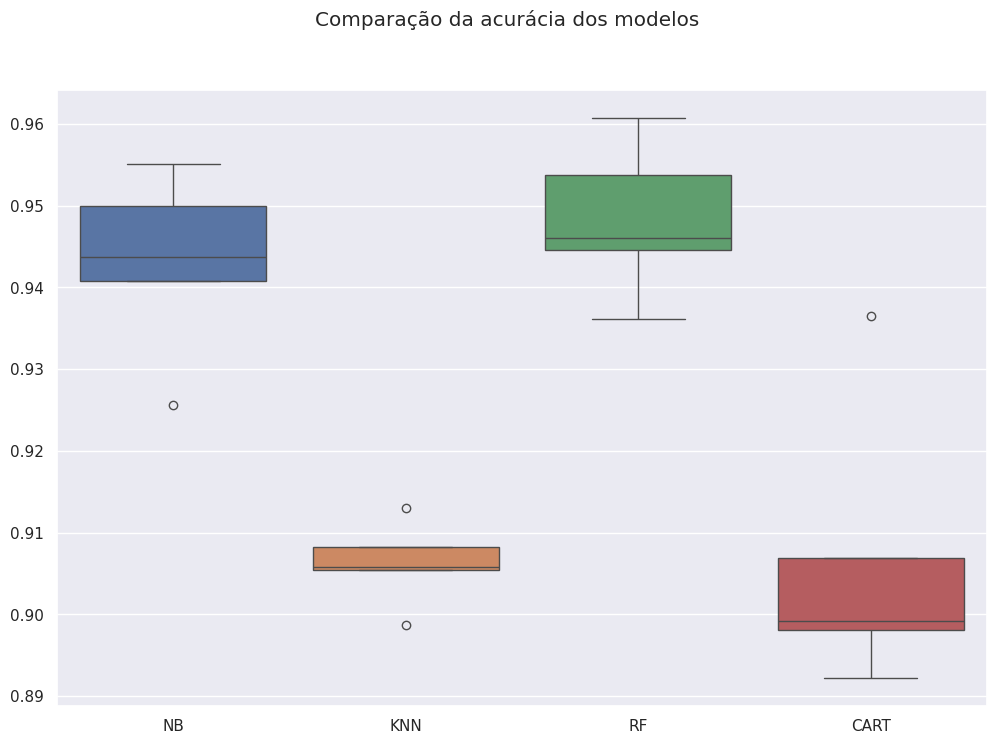

In [55]:
sns.set_theme()
names = ["NB", "KNN", "RF", "CART"]
fig, ax = plt.subplots(figsize=(12, 8))
fig.suptitle("Comparação da acurácia dos modelos")
ax.set_xticklabels(names)
sns.boxplot(results);

Assim foi escolhido Random Forest para prosseguir na otimização de hiperparâmetros

#### Otimização de Hiperparâmetros

In [56]:
def otimize_hyper(
    scoring: Literal["accuracy", "balanced_accuracy", "f1_macro"] = "accuracy",
    seed: int = 42,
    n_iter=20,
    n_jobs=3,
    cv=kfold,
    class_weight="balanced",
):
    model = RandomForestClassifier(random_state=seed, class_weight=class_weight)
    param_grid = {
        "n_estimators": [50, 100, 300],
        "max_depth": [None, 2, 5, 10],
        "min_samples_split": [2, 4, 5],
        "min_samples_leaf": [2, 4, 5],
    }

    random_search = RandomizedSearchCV(
        model,
        param_grid,
        cv=cv,
        scoring=scoring,
        n_iter=n_iter,
        n_jobs=n_jobs,
        random_state=seed,
    )
    random_search.fit(X_chest_train_pre, y_chest_train.ravel())
    print(f"O melhor modelo teve parâmetros:{random_search.best_params_}")
    print(f"O melhor score foi:{random_search.best_score_:.2f}")
    return random_search.best_estimator_

In [57]:
final_clf = otimize_hyper(scoring="precision",class_weight="balanced",n_jobs=2,n_iter=5)

O melhor modelo teve parâmetros:{'n_estimators': 300, 'min_samples_split': 4, 'min_samples_leaf': 5, 'max_depth': 5}
O melhor score foi:0.97


In [58]:
final_model = Pipeline([("Preprocessamento", pre), ("Classificador", final_clf)])

In [59]:
cv = 3
#y_chest_predict_val = cross_val_predict(final_model,X_chest_train,y_chest_train.ravel(),cv=cv)
#y_chest_score_val = cross_val_score(final_model,X_chest_train,y_chest_train.ravel(),cv=cv)
predict_proba=final_model.predict_proba(X_chest_train)


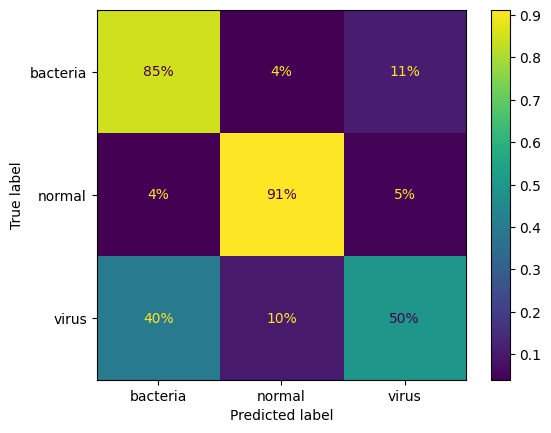

In [26]:
ConfusionMatrixDisplay.from_predictions(
    y_chest_train, y_chest_predict_val, normalize="true", values_format="0.0%"
)
plt.grid(False)

In [25]:
from sklearn.metrics import precision_recall_curve
precisions,recalls,thresholds = precision_recall_curve(y_chest_train,predict_proba[:,0],pos_label="normal")

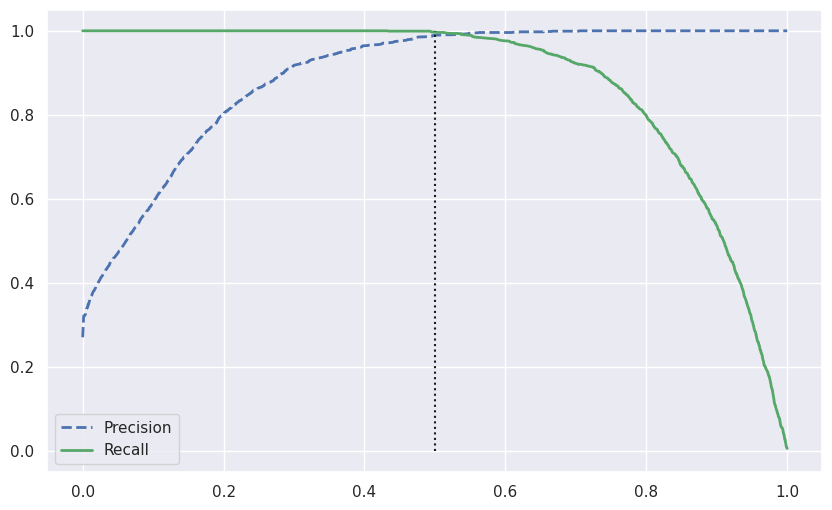

In [26]:
sns.set_theme()
fig,ax = plt.subplots(figsize=(10,6))
ax.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
ax.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
ax.legend()
ax.vlines(0.5, 0, 1.0, "k", "dotted", label="threshold")
plt.show()

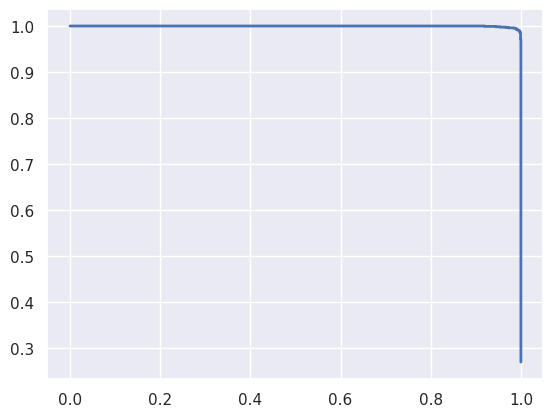

In [27]:
plt.plot(recalls, precisions, linewidth=2, label="Precision/Recall curve")
plt.show()

### Avaliação de Resultados

In [60]:
final_model.fit(X_chest_train, y_chest_train)

Pipeline(steps=[('Preprocessamento',
                 Pipeline(steps=[('converte_float',
                                  FunctionTransformer(func=<function <lambda> at 0x7eff419b79c0>)),
                                 ('normalizacao', StandardScaler())])),
                ('Classificador',
                 RandomForestClassifier(class_weight='balanced', max_depth=5,
                                        min_samples_leaf=5, min_samples_split=4,
                                        n_estimators=300, random_state=42))])

#### Métricas de Avaliação

In [63]:
y_chest_predict = final_model.predict(X_chest_test)

##### Acurácia

In [64]:
accuracy_score(y_chest_test, y_chest_predict)

0.909556313993174

##### Matriz de confusão

A matriz de confusão abaixo nos permite analisar como se distribuem
as previsões de cada classe a aprtir da comparação com as classes
verdadeiras.

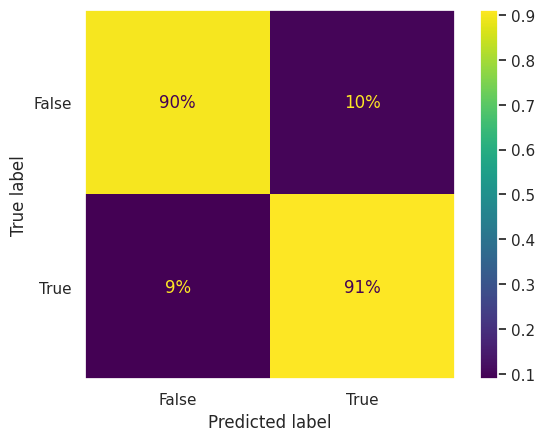

In [65]:
ConfusionMatrixDisplay.from_predictions(
    y_chest_test, y_chest_predict, normalize="true", values_format="0.0%"
)
plt.grid(False)

Percebe-se que as classes `bacteria` e `normal` tiveram bom desempenho nessa métrica,
uma vez que ambos mais de 85% das previsões são corretas, ou seja, o modelo consegue identificar corretamente a maior parte dos casos em que o paciente tem pneumonia causada por bacteria ou em que o paciente é saudável. 

Entretanto, o modelo não tem bom desempenho ao tentar classificar a pneumonia virótica, visto que a maioria das previsões foram incorretas. Nesse caso a maior dificuldade foi em diferenciar a pneumonia virótica da pneumonia bacteriana.

A partir da matriz de confusão acima, que leva em conta a distibuição dos erros e predição, percebe-se a dificuldade do modelo de diferenciar entre pneumonia causada por bactéria e por vírus. Além disso o modelo distribui igualmente o erro de classificação no caso de paciente saudável para as classes `bacteria` e `normal`, demonstrando mais uma vez a dificuldade de diferenciação entre as duas classes.

##### Precisão

In [66]:
print(
    "Precisão de cada classe:",
    precision_score(y_chest_test, y_chest_predict)
)

Precisão de cada classe: 0.9617755856966708


Como existe desbalanceamento das classes (bacteria é bem mais comum) será utilizada a
métrica de precisão ponderada.

##### Recall

In [68]:
print(
    "Recall de cada classe:", recall_score(y_chest_test, y_chest_predict)
)

Recall de cada classe: 0.9122807017543859


Como existe desbalanceamento das classes (bacteria é bem mais comum) será utilizada a
métrica de recall ponderada.

##### Curva ROC

In [69]:
y_chest_pproba = final_model.predict_proba(X_chest_test)

In [80]:
def plot_roc(y_true: npt.ArrayLike, y_score: npt.ArrayLike):

    sns.set_theme()
    _, ax = plt.subplots(figsize=(10, 10))

    fpr, tpr, _ = roc_curve(y_true, y_score[:, 1])
    auc = roc_auc_score(y_true, y_score[:, 1])
    ax.plot(fpr, tpr, lw=2,c="red", label=f"(AUC = {auc:.2f})")

    ax.plot(
        [0, 1], [0, 1], label="Classificador Aleatório (AUC = 0.5)"
    )  # Plota classificador aleatório
    ax.plot(
        [0, 0, 1], [0, 1, 1], label="Classificador Perfeito (AUC = 1.0)"
    )  # Plota classificador perfeito

    ax.grid(True)
    ax.legend()
    plt.show()

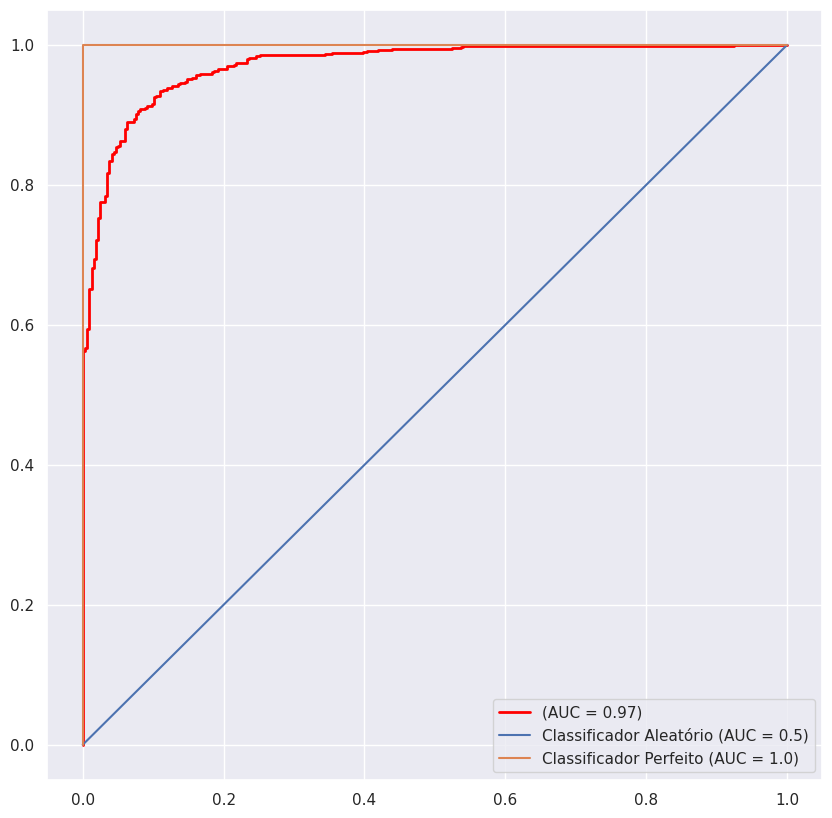

In [81]:
plot_roc(y_chest_test, y_chest_pproba)